In [1]:
import numpy as np
import os
import tqdm
from scipy.signal import stft

from sklearn.metrics import classification_report
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import random
import os
import numpy as np
from PIL import Image
import tqdm

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Torchvision
import torchvision
from torchvision import transforms, models
from torchvision.models.feature_extraction import create_feature_extractor

# Transformers (Hugging Face CLIP)
from transformers import CLIPModel, CLIPProcessor

# Scikit-learn
from sklearn.linear_model import RidgeClassifier

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer

import torchmetrics
from torchmetrics import Accuracy

!pip install monai
import monai
from monai.networks import nets
from torchsummary import summary
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

eeg_data_train= np.load('/kaggle/input/preprocessed-17-channel-things-eeg-2-sub-01/sub-01/preprocessed_eeg_training.npy', allow_pickle=True).item()
img_metadata = np.load("/kaggle/input/things-eeg-2-images/image_metadata.npy",
	allow_pickle=True).item()

eeg_path=["/kaggle/input/preprocessed-17-channel-things-eeg-2-sub-01/sub-01/preprocessed_eeg_training.npy",
         "/kaggle/input/preprocessed-17-channel-things-eeg-2-sub-02-to-07/sub-02/sub-02/preprocessed_eeg_training.npy",
         "/kaggle/input/preprocessed-17-channel-things-eeg-2-sub-02-to-07/sub-03/sub-03/preprocessed_eeg_training.npy",
         "/kaggle/input/preprocessed-17-channel-things-eeg-2-sub-02-to-07/sub-04/sub-04/preprocessed_eeg_training.npy",
         "/kaggle/input/preprocessed-17-channel-things-eeg-2-sub-02-to-07/sub-05/sub-05/preprocessed_eeg_training.npy",
         "/kaggle/input/preprocessed-17-channel-things-eeg-2-sub-02-to-07/sub-06/sub-06/preprocessed_eeg_training.npy",
         "/kaggle/input/preprocessed-17-channel-things-eeg-2-sub-02-to-07/sub-07/sub-07/preprocessed_eeg_training.npy",
          "/kaggle/input/preprocessed-17-channel-things-eeg-2-sub-8-9-10/sub-08/sub-08/preprocessed_eeg_training.npy",
          "/kaggle/input/preprocessed-17-channel-things-eeg-2-sub-8-9-10/sub-09/sub-09/preprocessed_eeg_training.npy",
          "/kaggle/input/preprocessed-17-channel-things-eeg-2-sub-8-9-10/sub-10/sub-10/preprocessed_eeg_training.npy"
         ]

2025-10-02 05:54:40.579017: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759384480.601487     205 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759384480.608703     205 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<frozen importlib._bootstrap_external>:1241: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.


In [2]:
# Initialize empty lists
real_train_img_idx = []
real_valid_img_idx = []
real_test_img_idx = []

random.seed(42)

# Process each group of 10 numbers (0-9, 10-19, ..., 90-99)
for group_start in range(0, 100, 10):
    group = list(range(group_start, group_start + 10))
    random.shuffle(group)
    
    # Take 1 for validation, 1 for test, and 8 for training from each group
    real_valid_img_idx.append(group[0])
    real_test_img_idx.append(group[1])
    real_train_img_idx.extend(group[2:10])

# Verify the results
print(f"Train: {len(real_train_img_idx)} numbers")  # 80
print(f"Valid: {len(real_valid_img_idx)} numbers")  # 10  
print(f"Test: {len(real_test_img_idx)} numbers")    # 10
print(f"All unique: {len(set(real_train_img_idx + real_valid_img_idx + real_test_img_idx)) == 100}")

Train: 80 numbers
Valid: 10 numbers
Test: 10 numbers
All unique: True


In [3]:
import numpy as np
import scipy.signal as signal
from scipy import ndimage

def augment_eeg(eeg_sample):
    """
    Apply multiple augmentations to a single EEG sample
    Input shape: (4, 17, 100)
    Output shape: (6, 4, 17, 100) - original + 5 augmentations
    """
    augmented_data = []
    
    # # 1. Gaussian noise
    # noisy_sample = add_gaussian_noise(eeg_sample)
    # augmented_data.append(noisy_sample)
    
    # 2. Time warping
    warped_sample = time_warp(eeg_sample)
    augmented_data.append(warped_sample)
    
    # # 3. Channel dropout
    # dropout_sample = channel_dropout(eeg_sample)
    # augmented_data.append(dropout_sample)
    
    # # 4. Frequency filtering variations
    # filtered_sample = frequency_variation(eeg_sample)
    # augmented_data.append(filtered_sample)
    
    # # 5. Amplitude scaling
    # scaled_sample = amplitude_scaling(eeg_sample)
    # augmented_data.append(scaled_sample)
    
    return augmented_data

def add_gaussian_noise(sample, noise_level=0.01):
    """Add Gaussian noise to EEG signal"""
    noise = np.random.normal(0, noise_level, sample.shape)
    return sample + noise

def time_warp(sample, warp_factor=0.1):
    """Apply time warping to EEG signals"""
    n_channels, n_electrodes, n_timepoints = sample.shape
    warped_sample = np.zeros_like(sample)
    
    for c in range(n_channels):
        for e in range(n_electrodes):
            # Create warping function
            warp_points = np.linspace(0, n_timepoints-1, num=5)
            warp_values = np.random.uniform(-warp_factor, warp_factor, 5)
            warp_function = np.interp(np.arange(n_timepoints), warp_points, warp_values)
            
            # Apply warping
            warped_timepoints = np.arange(n_timepoints) + warp_function * n_timepoints
            warped_timepoints = np.clip(warped_timepoints, 0, n_timepoints-1)
            
            warped_sample[c, e] = np.interp(np.arange(n_timepoints), 
                                           warped_timepoints, 
                                           sample[c, e])
    
    return warped_sample

def channel_dropout(sample, dropout_prob=0.2):
    """Randomly dropout some channels"""
    n_channels, n_electrodes, n_timepoints = sample.shape
    mask = np.random.binomial(1, 1-dropout_prob, (n_channels, n_electrodes, 1))
    return sample * mask

def frequency_variation(sample, lowcut=0.5, highcut=30.0, fs=100):
    """Apply random frequency filtering variations"""
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    
    # Randomly vary filter parameters
    random_low = np.random.uniform(lowcut * 0.8, lowcut * 1.2)
    random_high = np.random.uniform(highcut * 0.9, highcut * 1.1)
    
    b, a = signal.butter(4, [random_low/nyquist, random_high/nyquist], btype='band')
    
    filtered_sample = np.zeros_like(sample)
    for c in range(sample.shape[0]):
        for e in range(sample.shape[1]):
            filtered_sample[c, e] = signal.filtfilt(b, a, sample[c, e])
    
    return filtered_sample

def amplitude_scaling(sample, scale_range=(0.8, 1.2)):
    """Randomly scale amplitude of signals"""
    scale_factor = np.random.uniform(scale_range[0], scale_range[1])
    return sample * scale_factor

In [4]:

img_parent_dir='/kaggle/input/things-eeg-2-images/training_images'
eeg_train=[]
eeg_val=[]
eeg_test=[]

subject_train=[]
subject_val=[]
subject_test=[]


img_train=[]
img_val=[]
img_test=[]

label_train=[]
label_val=[]
label_test=[]

label_train_encoded=[]
label_val_encoded=[]
label_test_encoded=[]

augmentation_number=1
img_idx_train_list=[]
img_idx_val_list=[]
img_idx_test_list=[]

for sub in range(10):
    eeg_data_train= np.load(eeg_path[sub], allow_pickle=True).item()
    for i in real_train_img_idx:
        eeg=eeg_data_train['preprocessed_eeg_data'][i]
        img_idx=i
        img_name=os.path.join(img_parent_dir, 'training_images',
    	      img_metadata['train_img_concepts'][i],
    	       img_metadata['train_img_files'][i])
        label=img_metadata['train_img_concepts'][i]
        class_name=int(label.split('_', 1)[0]) - 1
        subject=0
    
        eeg_train.append(eeg)
        img_train.append(img_name)   #image name is really the file address 
        label_train.append(label)
        label_train_encoded.append(class_name)
        subject_train.append(subject)
        img_idx_train_list.append(img_idx)
        # eeg=augment_eeg(eeg)
        # eeg_train.extend(eeg)

        # for n in range(augmentation_number):
        #     img_idx=i
        #     img_name=os.path.join(img_parent_dir, 'training_images',
        # 	      img_metadata['train_img_concepts'][i],
        # 	       img_metadata['train_img_files'][i])
        #     label=img_metadata['train_img_concepts'][i]
        #     class_name=int(label.split('_', 1)[0]) - 1
        #     subject=0
        
           
        #     img_train.append(img_name)   #image name is really the file address 
        #     label_train.append(label)
        #     label_train_encoded.append(class_name)
        #     subject_train.append(subject)
        #     img_idx_train_list.append(img_idx)
                
    
    
    
    for i in real_valid_img_idx:
        eeg=eeg_data_train['preprocessed_eeg_data'][i]
        img_idx=i
        img_name=os.path.join(img_parent_dir, 'training_images',
    	      img_metadata['train_img_concepts'][i],
    	       img_metadata['train_img_files'][i])
        label=img_metadata['train_img_concepts'][i]
        class_name=int(label.split('_', 1)[0]) - 1
        subject=0
    
        eeg_val.append(eeg)
        img_val.append(img_name)   #image name is really the file address 
        label_val.append(label)
        label_val_encoded.append(class_name)
        subject_val.append(subject)
        img_idx_val_list.append(img_idx)
        # eeg=augment_eeg(eeg)
        # eeg_val.extend(eeg)

        # for n in range(augmentation_number):
        #     img_idx=i
        #     img_name=os.path.join(img_parent_dir, 'training_images',
        # 	      img_metadata['train_img_concepts'][i],
        # 	       img_metadata['train_img_files'][i])
        #     label=img_metadata['train_img_concepts'][i]
        #     class_name=int(label.split('_', 1)[0]) - 1
        #     subject=0
        
           
        #     img_val.append(img_name)   #image name is really the file address 
        #     label_val.append(label)
        #     label_val_encoded.append(class_name)
        #     subject_val.append(subject)
        #     img_idx_val_list.append(img_idx)
    
    for i in real_test_img_idx:
        eeg=eeg_data_train['preprocessed_eeg_data'][i]
        img_idx=i
        img_name=os.path.join(img_parent_dir, 'training_images',
    	      img_metadata['train_img_concepts'][i],
    	       img_metadata['train_img_files'][i])
        label=img_metadata['train_img_concepts'][i]
        class_name=int(label.split('_', 1)[0]) - 1
        subject=0
    
        eeg_test.append(eeg)
        img_test.append(img_name)   #image name is really the file address 
        label_test.append(label)
        label_test_encoded.append(class_name)
        subject_test.append(subject)
        img_idx_test_list.append(img_idx)


In [5]:

spectro_train=[]
spectro_val=[]
spectro_test=[]


# Process training data
for eeg in tqdm.tqdm(eeg_train, desc="Processing train data"):
    sample_spectrograms = []
    
    # Iterate through session number (4) and channels (17)
    for freq_band in range(eeg.shape[0]):  # 4 sessions
        band_spectrograms = []
        for channel in range(eeg.shape[1]):  # 17 channels
            # Apply STFT to each channel's time series (100 time points)
            f, t, Zxx = stft(eeg[freq_band, channel, :], fs=1000, nperseg=40)
            band_spectrograms.append(np.abs(Zxx))
        sample_spectrograms.append(np.stack(band_spectrograms))
    
    spectro_train.append(torch.tensor(np.stack(sample_spectrograms)))

# Process validation data
for eeg in tqdm.tqdm(eeg_val, desc="Processing validation data"):
    sample_spectrograms = []
    
    for freq_band in range(eeg.shape[0]):  # 4 frequency bands
        band_spectrograms = []
        for channel in range(eeg.shape[1]):  # 17 channels
            f, t, Zxx = stft(eeg[freq_band, channel, :], fs=1000, nperseg=40)
            band_spectrograms.append(np.abs(Zxx))
        sample_spectrograms.append(np.stack(band_spectrograms))
    
    spectro_val.append(torch.tensor(np.stack(sample_spectrograms)))

# Process test data
for eeg in tqdm.tqdm(eeg_test, desc="Processing test data"):
    sample_spectrograms = []
    
    for freq_band in range(eeg.shape[0]):  # 4 frequency bands
        band_spectrograms = []
        for channel in range(eeg.shape[1]):  # 17 channels
            f, t, Zxx = stft(eeg[freq_band, channel, :], fs=1000, nperseg=40)
            band_spectrograms.append(np.abs(Zxx))
        sample_spectrograms.append(np.stack(band_spectrograms))
    
    spectro_test.append(torch.tensor(np.stack(sample_spectrograms)))

# Stack all spectrograms
spectro_train = torch.stack(spectro_train)
spectro_val = torch.stack(spectro_val)
spectro_test = torch.stack(spectro_test)

print(f"Training spectrograms shape: {spectro_train.shape}")
print(f"Validation spectrograms shape: {spectro_val.shape}")
print(f"Test spectrograms shape: {spectro_test.shape}")

Processing test data: 100%|██████████| 100/100 [00:01<00:00, 91.83it/s]

Training spectrograms shape: torch.Size([800, 4, 17, 21, 6])
Validation spectrograms shape: torch.Size([100, 4, 17, 21, 6])
Test spectrograms shape: torch.Size([100, 4, 17, 21, 6])


In [50]:
import ast
import pandas as pd

df = pd.read_csv('/kaggle/input/clip-laion-clip-vit-h-14-laion2b-s32b-b79k/only_text_laion_CLIP-ViT-H-14-laion2B-s32B-b79K_embeddings.csv')
idx_to_embedding = dict(zip(df['idx'], df['clip_img_embeds']))
train_clip_img_embed=[]
val_clip_img_embed=[]
test_clip_img_embed=[]
for p in range(len(eeg_train)):
    target_idx = img_idx_train_list[p]
    train_clip_one = idx_to_embedding[target_idx]
    train_clip_img_embed.append(torch.tensor(ast.literal_eval(train_clip_one))) 
train_clip_img_embeds = torch.stack(train_clip_img_embed)  


for p in range(len(eeg_val)):
    target_idx = img_idx_val_list[p]
    val_clip_one = idx_to_embedding[target_idx]
    val_clip_img_embed.append(torch.tensor(ast.literal_eval(val_clip_one)))
val_clip_img_embeds = torch.stack(val_clip_img_embed)    


for p in range(len(eeg_test)):
    target_idx = img_idx_test_list[p]
    test_clip_one = idx_to_embedding[target_idx]
    test_clip_img_embed.append(torch.tensor(ast.literal_eval(test_clip_one)))
test_clip_img_embeds = torch.stack(test_clip_img_embed)

In [51]:
# for p in range(len(eeg_train)):
#     target_idx = img_idx_train_list[p]
#     train_clip_one = idx_to_embedding[target_idx]
#     array_str = train_clip_one.replace('tensor(', '').replace(')', '')
#     array_data = eval(array_str)  # This will create a list of numbers
    
#     train_clip_img_embed.append(torch.tensor(array_data, dtype=torch.float32))
#     # train_clip_img_embed.append(torch.tensor(ast.literal_eval(train_clip_one))) 
# train_clip_img_embeds = torch.stack(train_clip_img_embed)  


# for p in range(len(eeg_val)):
#     target_idx = img_idx_val_list[p]
#     val_clip_one = idx_to_embedding[target_idx]
#     array_str = val_clip_one.replace('tensor(', '').replace(')', '')
#     array_data = eval(array_str)  # This will create a list of numbers
    
#     val_clip_img_embed.append(torch.tensor(array_data, dtype=torch.float32))
#     # val_clip_img_embed.append(torch.tensor(ast.literal_eval(val_clip_one)))
# val_clip_img_embeds = torch.stack(val_clip_img_embed)  

# test_clip_img_embed=[]
# for p in range(len(eeg_test)):
#     target_idx = img_idx_test_list[p]
#     test_clip_one = idx_to_embedding[target_idx]
#     array_str = test_clip_one.replace('tensor(', '').replace(')', '')
#     array_data = eval(array_str)  # This will create a list of numbers
    
#     test_clip_img_embed.append(torch.tensor(array_data, dtype=torch.float32))
#     # test_clip_img_embed.append(torch.tensor(ast.literal_eval(test_clip_one)))
# test_clip_img_embeds = torch.stack(test_clip_img_embed) 

In [52]:
train_clip_img_embeds.shape
print(np.unique(label_train_encoded))

[0 1 2 3 4 5 6 7 8 9]


In [53]:
batch=8
distill_know=True
class LinearClassifier(pl.LightningModule):
    def __init__(self,n_classes, lr=3e-4):
        super(LinearClassifier, self).__init__()

        self.n_classes = n_classes
        self.lr = lr

        self.fc = nn.LazyLinear( n_classes)

        self.loss = nn.CrossEntropyLoss()
       


    def forward(self, x):
        logits = self.fc(x)
        return logits

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        logits = self.forward(inputs)
        loss = self.loss(logits, targets.long())

        preds = torch.argmax(F.softmax(logits, dim=1), dim=1)
        acc = torch.sum(preds == targets).item() / targets.size(0)

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        logits = self.forward(inputs)
        loss = self.loss(logits, targets.long())

        preds = torch.argmax(F.softmax(logits, dim=1), dim=1)
        acc = torch.sum(preds == targets).item() / targets.size(0)

        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True)

        return loss
















    
            
    #         loss_base = self.loss(outputs, targets)
    #     else:
    #         loss_base = self.loss(outputs, targets)
    #         loss_teacher = 0
        
    #     loss = loss_base + loss_teacher
    #     acc = self.accuracy(outputs_prob, targets)
        
    #     self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    #     self.log("val_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
    #     return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

clip_head_classifier=LinearClassifier(n_classes=10)

clip_features_train_dataset=torch.utils.data.TensorDataset(train_clip_img_embeds[:,:],torch.tensor(label_train_encoded, dtype=torch.long))
clip_features_val_dataset=torch.utils.data.TensorDataset(val_clip_img_embeds[:,:],torch.tensor(label_val_encoded, dtype=torch.long))
# clip_features_test_dataset=torch.utils.data.TensorDataset(test_clip_img_embeds[:,0,:],torch.tensor(label_test))

# Create dataloaders
train_loader = DataLoader(clip_features_train_dataset, batch_size=batch, shuffle=True)
val_loader = DataLoader(clip_features_val_dataset, batch_size=batch)
#test_loader = DataLoader(clip_features_test_dataset, batch_size=batch)

trainer = Trainer(devices=1,max_epochs=5)
trainer.fit(clip_head_classifier, train_loader, val_loader)


class CNNClassifier(pl.LightningModule):
    def __init__(self, cnn_model,teaching_clip_head=None, lr=1e-3,scale=1., distill_knowledge=distill_know):
        super(CNNClassifier, self).__init__()

        self.cnn_model = cnn_model
        self.teaching_clip_head=teaching_clip_head
        self.lr = lr
        self.scale=scale
        self.softmax=torch.nn.Softmax(-1)
        self.distill_knowledge=distill_knowledge

        self.accuracy = Accuracy(task='multiclass', num_classes=8)
        self.loss = nn.CrossEntropyLoss()


    def forward(self, x):
        return self.cnn_model(x)

    def training_step(self, batch, batch_idx):
        inputs, features, targets = batch
        outputs = self.forward(inputs)
        
        loss_base = self.loss(outputs,targets.long())

        if self.distill_knowledge:
            teacher_outputs=self.teaching_clip_head(features)

            outputs_prob=self.softmax(outputs)
        
            teacher_prob=self.softmax(teacher_outputs)

            loss_teacher = self.loss(outputs_prob, teacher_prob)*self.scale
            loss_base = self.loss(outputs,targets.long())

            loss =0.3* loss_base +0.3* loss_teacher
        else:
            loss = loss_base
        _, predicted = torch.max(outputs, 1)
        acc = torch.sum(predicted == targets).item() / targets.size(0)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True)

        return loss


    def validation_step(self, batch, batch_idx):
        spectro, feat, targets = batch
        outputs = self(spectro)
        outputs_prob = self.softmax(outputs)
        
        if self.distill_knowledge:
            teacher_outputs = self.teaching_clip_head(feat)
            teacher_prob = self.softmax(teacher_outputs)
            
            # Fix: Use KL divergence for knowledge distillation instead of CrossEntropyLoss
            # CrossEntropyLoss expects class indices, not probability distributions
            loss_teacher = F.kl_div(
                F.log_softmax(outputs, dim=-1), 
                teacher_prob, 
                reduction='batchmean'
            ) * self.scale
            
            loss_base = self.loss(outputs, targets.long())
        else:
            loss_base = self.loss(outputs, targets.long())
            loss_teacher = 0
        
        loss = loss_base + loss_teacher
        acc = self.accuracy(outputs_prob, targets.long())
        
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,weight_decay=1e-2)
        return optimizer

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [54]:


class KnowledgeClassifierDataset(torch.utils.data.Dataset):
    def __init__(self,spectro,features,labels,spec_transform=None):
        super().__init__()
        self.spectro=spectro
        self.features=features
        self.labels=labels
        self.spec_transform=spec_transform
        
    def __len__(self):
        return len(self.spectro)

    def __getitem__(self, idx):
        
        
        eeg=self.spectro[idx]
        feat=self.features[idx]
       
        if self.spec_transform:
            eeg=self.spec_transform(eeg)
        
        
        labels=self.labels[idx]
        
        return eeg,feat,labels

train_clip_img_embeds.shape



torch.Size([800, 1024])

In [55]:
# spectro_train = torch.load("/kaggle/input/spectrogram-2000-400-200/spectro_train.pt")
# spectro_val = torch.load("/kaggle/input/spectrogram-2000-400-200/spectro_val.pt")
# spectro_test = torch.load("/kaggle/input/spectrogram-2000-400-200/spectro_test.pt")

In [56]:
spectro_test.shape

torch.Size([100, 4, 17, 21, 6])

In [57]:
spectro_test = spectro_test[:, np.arange(4), :, :, :]
spectro_test.shape


torch.Size([100, 4, 17, 21, 6])

In [58]:
spectro_train.shape
spectro_val.shape

torch.Size([100, 4, 17, 21, 6])

In [59]:
subj_train_array=np.array(subject_train)
subj_val_array=np.array(subject_val)
subj_test_array=np.array(subject_test)

# spectro_train[subj_train_array==subj_idx]
# label_train[subj_train_array==subj_idx]

spec_transforms=torchvision.transforms.Compose([torchvision.transforms.Resize((32,32))])
single_subject=True
subj_idx=0

# for subj_idx in [0,1,2,3,4,5,6]:
    

print(subj_val_array.shape)



(100,)


In [60]:
 # print(f"[INFO] Processing {subj_idx}")
 #    if not single_subject:

 #        train_know_dataset = KnowledgeClassifierDataset(spectro_train.to(torch.float32), train_clip_img_embeds[:,:].to(torch.float32),label_train_encoded,spec_transform=spec_transforms)
 #        val_know_dataset = KnowledgeClassifierDataset(spectro_val.to(torch.float32), val_clip_img_embeds[:,:].to(torch.float32),label_val_encoded,spec_transform=spec_transforms)
 #    #     test_know_dataset = KnowledgeClassifierDataset(spectro_test, test_clip_img_embeds[:,0,:],label_test,spec_transform=spec_transforms)
 #    else:
 #        # Check if subject has data
 #        train_mask = subj_train_array==subj_idx
 #        val_mask = subj_val_array==subj_idx
        
 #        if train_mask.sum() == 0 or val_mask.sum() == 0:
 #            print(f"[WARNING] Subject {subj_idx} has no training or validation data, skipping...")
 #            continue
            
 #        train_know_dataset = KnowledgeClassifierDataset(spectro_train[train_mask].to(torch.float32), train_clip_img_embeds[:,:][train_mask].to(torch.float32),torch.tensor(label_train_encoded)[train_mask],spec_transform=spec_transforms)
 #        val_know_dataset = KnowledgeClassifierDataset(spectro_val[val_mask].to(torch.float32), val_clip_img_embeds[:,:][val_mask].to(torch.float32),torch.tensor(label_val_encoded)[val_mask],spec_transform=spec_transforms)
 #        # test_know_dataset = KnowledgeClassifierDataset(spectro_test[subj_test_array==subj_idx], test_clip_img_embeds[:,0,:][subj_test_array==subj_idx],torch.tensor(label_test)[subj_test_array==subj_idx],spec_transform=spec_transforms)
print(f"[INFO] Processing {subj_idx}")
if not single_subject:
    train_know_dataset = KnowledgeClassifierDataset(
        spectro_train.to(torch.float32), 
        train_clip_img_embeds[:,:].to(torch.float32),
        label_train_encoded,
        spec_transform=spec_transforms
    )
    val_know_dataset = KnowledgeClassifierDataset(
        spectro_val.to(torch.float32), 
        val_clip_img_embeds[:,:].to(torch.float32),
        label_val_encoded,
        spec_transform=spec_transforms
    )
else:
    # Check if subject has data
    train_mask = subj_train_array == subj_idx
    val_mask = subj_val_array == subj_idx
    
    if train_mask.sum() == 0 or val_mask.sum() == 0:
        print(f"[WARNING] Subject {subj_idx} has no training or validation data, skipping...")
    else:    
        train_know_dataset = KnowledgeClassifierDataset(
            spectro_train[train_mask].to(torch.float32), 
            train_clip_img_embeds[:,:][train_mask].to(torch.float32),
            torch.tensor(label_train_encoded)[train_mask],
            spec_transform=spec_transforms
        )
        val_know_dataset = KnowledgeClassifierDataset(
            spectro_val[val_mask].to(torch.float32), 
            val_clip_img_embeds[:,:][val_mask].to(torch.float32),
            torch.tensor(label_val_encoded)[val_mask],
            spec_transform=spec_transforms
        )

[INFO] Processing 0


In [61]:
train_know_dataloader = torch.utils.data.DataLoader(train_know_dataset, batch_size=32, shuffle=True)
val_know_dataloader = torch.utils.data.DataLoader(val_know_dataset, batch_size=32, shuffle=False)
# test_know_dataloader=torch.utils.data.DataLoader(test_know_dataset,batch_size=64,shuffle=False)

In [62]:
len(train_know_dataloader)


25

In [63]:
from torchsummary import summary
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [68]:


# model
base_model = nets.Classifier(
    in_shape=(4,17, 32, 32),
    classes=10,
    channels=[128, 128, 64, 64, 128, 128],
    # channels=[128, 128, 256],
    strides=[2, 1, 2, 1, 2, 2],
    # strides=[2, 1, 2],
    kernel_size=3,
    num_res_units=1,
    act="GELU",
    norm=("GROUP", {"num_groups": 8}),
    dropout=0
)


# base_model = nets.Classifier(
#     in_shape=(17, 32, 32),  # Spatial dims for EEG (assuming 4 channels handled in custom conv layer)
#     classes=10,  # Matches your 10-class visual decoding task
#     channels=[256, 256, 256, 128, 128, 256, 256, 512],  # Deeper and wider for complex EEG patterns
#     strides=[2, 1, 1, 2, 1, 2, 1, 2],  # Gradual downsampling to preserve temporal resolution
#     kernel_size=5,  # Larger kernels to capture broader spatiotemporal interactions
#     num_res_units=3,  # More residual units for better feature propagation
#     act="GELU",  # Retained for superior performance over SELU
#     norm=("GROUP", {"num_groups": 16}),  # Group norm with scaled groups for stability
#     dropout=0.1,  # Lowered to reduce over-regularization
#     spatial_dims=3  # Explicitly set for 3D EEG data
# )


# base_model = nets.Classifier(
#     in_shape=(4, 17, 32, 32),
#     classes=10,
#     channels=[64, 128, 128, 256, 256, 512],
#     strides=[1, 2, 1, 2, 1, 2],
#     kernel_size=3,
#     num_res_units=2,
#     act="SWISH",                       # same as SiLU
#     norm="BATCH", # ✅ better for batch size 8
#     dropout=0.3
# )


# base_model=EEGConvClfModel(channels=[128, 128,128])
cnn = CNNClassifier(
    base_model,
    teaching_clip_head=clip_head_classifier,
    lr=3e-4,
    scale=1,
    distill_knowledge=distill_know
)
summary(cnn, (4,17, 32, 32), device="cpu")

early_stop_callback = EarlyStopping(
    monitor='val_acc',
    min_delta=0.00,
    patience=10,
    verbose=False,
    mode='max'
)

cnn.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)


trainer = Trainer(devices=1, max_epochs=50, callbacks=[early_stop_callback])
trainer.fit(cnn, train_know_dataloader, val_know_dataloader)
trainer.save_checkpoint(f"models/subj_{subj_idx}.pt")

y_pred = []
y_true = []
with torch.no_grad():
    for spectro, feat, labels in tqdm.tqdm(val_know_dataloader, position=0):
        y_pred.append(cnn(spectro))
        y_true.append(labels)

    y_pred = torch.cat(y_pred)
    y_true = torch.cat(y_true)

report = classification_report(y_true.numpy(), y_pred.argmax(-1).numpy(), output_dict=True,zero_division=0)
df = pd.DataFrame(report).transpose()
print(df)
# wandb.log({f"report_{subj_idx}": df})

# cnn=Encoder(num_input_channels=128,base_channel_size=64,latent_dim=40)
# # cnn=CNNRegressor(cnn,lr=1e-3,scale=1e3)
# cnn= CNNClassifier(cnn,teaching_clip_head=clip_head_classifier,lr=3e-4,scale=1)
# summary(cnn, (128,32,32),device="cpu")

# base_model = nets.Classifier(in_shape=(128,32,32),classes=40,channels=[64,64,128,128,128,128],strides=[2,1,2,1,2,2],kernel_size=3, num_res_units=1, act='GELU', norm="BATCH", dropout=0.1)
# # base_model=EEGConvClfModel(channels=[128, 128,128])
# cnn= CNNClassifier(base_model,teaching_clip_head=clip_head_classifier,lr=3e-4,scale=1,distill_knowledge=True)
# summary(cnn, (128,32,32),device="cpu")

# trainer = Trainer(devices=1,max_epochs=50)
# trainer.fit(cnn, train_know_dataloader, test_know_dataloader)

# y_pred=[]
# y_true=[]
# for spectro, feat, labels in tqdm.tqdm(test_know_dataloader,position=0):
#     y_pred.append(cnn(spectro))
#     y_true.append(labels)

# y_pred=torch.cat(y_pred)
# y_true=torch.cat(y_true)

# subj_test_array=np.array(subject_test)

# report=classification_report(y_true.numpy(),y_pred.argmax(-1).numpy(),output_dict=True)
# df = pd.DataFrame(report).transpose()
# df

# wandb.log({f"report_{subj_idx}": df})

# df

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 128, 9, 16, 16]          13,952
            Conv3d-2       [-1, 128, 9, 16, 16]          13,952
         GroupNorm-3       [-1, 128, 9, 16, 16]             256
           Dropout-4       [-1, 128, 9, 16, 16]               0
              GELU-5       [-1, 128, 9, 16, 16]               0
      ResidualUnit-6       [-1, 128, 9, 16, 16]               0
          Identity-7       [-1, 128, 9, 16, 16]               0
            Conv3d-8       [-1, 128, 9, 16, 16]         442,496
         GroupNorm-9       [-1, 128, 9, 16, 16]             256
          Dropout-10       [-1, 128, 9, 16, 16]               0
             GELU-11       [-1, 128, 9, 16, 16]               0
     ResidualUnit-12       [-1, 128, 9, 16, 16]               0
           Conv3d-13         [-1, 256, 5, 8, 8]         884,992
           Conv3d-14         [-1, 256, 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

              precision  recall  f1-score  support
0              0.307692    0.40  0.347826    10.00
1              0.200000    0.20  0.200000    10.00
2              0.090909    0.10  0.095238    10.00
3              0.125000    0.10  0.111111    10.00
4              0.250000    0.20  0.222222    10.00
5              0.125000    0.10  0.111111    10.00
6              0.125000    0.20  0.153846    10.00
7              0.100000    0.10  0.100000    10.00
8              0.222222    0.20  0.210526    10.00
9              0.428571    0.30  0.352941    10.00
accuracy       0.190000    0.19  0.190000     0.19
macro avg      0.197440    0.19  0.190482   100.00
weighted avg   0.197440    0.19  0.190482   100.00


In [69]:
# import nltk
# from nltk.corpus import wordnet as wn

# def convert_synsets_to_names(synsets):
#     nltk.download('wordnet')  # Download WordNet corpus if not already downloaded

#     class_names = []
#     for synset_id in synsets:
#         synset = wn.synset_from_pos_and_offset(synset_id[0], int(synset_id[1:]))
#         class_name = synset.lemmas()[0].name()
#         class_names.append(class_name)

#     return class_names

# class_names=convert_synsets_to_names(data["labels"])

# syn_to_class = {k:v for k,v in zip(range(40),class_names)}

# syn_to_class

# class_names=['Outdoor and Tactical Equipment',
#  'Sports Equipment',
#  'Clothing and Accessories',
#  'Mixed Food and Small Objects',
#  'Home and Living',
#  'Plants and Nature',
#  'Animals',
#  'Food and Kitchen']

class_names=['aardvark',
'abacus',
'accordion',
'acorn',
'air_conditioner',
'air_mattress',
'air_pump',
'airbag',
'airboat',
'airplane']

syn_to_class={9:'airplane',8:'airboat',7:'airbag',6:'air_pump',5:'air_mattress',4:'air_conditioner',3:'acorn',2:'accordion',1:'abacus',0:'aardvark'}





Text(0.5, 1.0, 'acorn')

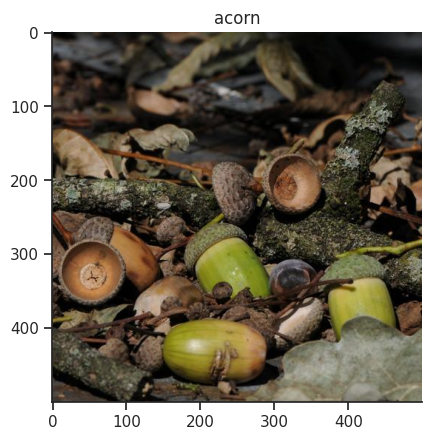

In [70]:
idx=3
plt.imshow(Image.open(img_test[idx]))
plt.title(syn_to_class[label_test_encoded[idx]])



processing 0


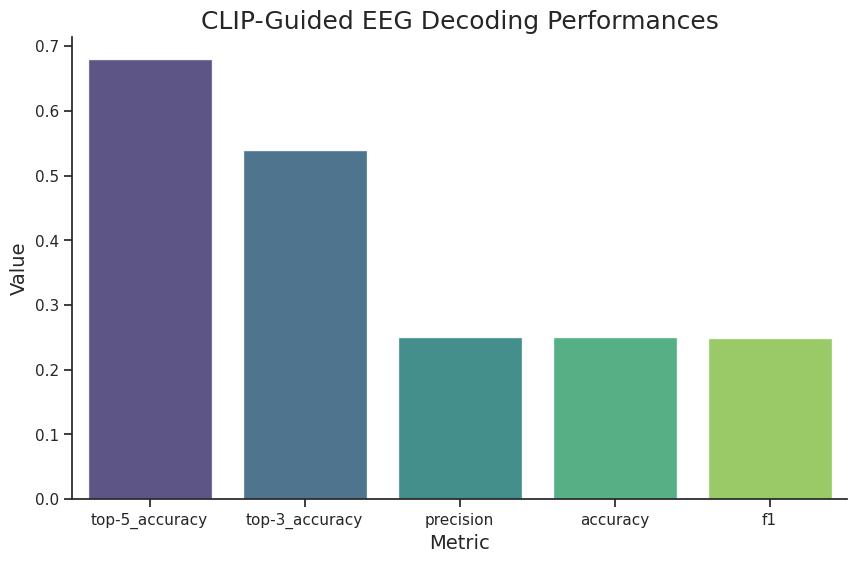

accuracy: 0.25
top-3_accuracy: 0.54
top-5_accuracy: 0.68
f1: 0.24823359646889057
precision: 0.2503896103896104
recall: 0.24999999999999994


precision  recall  f1-score  support
aardvark          0.375000    0.30  0.333333    10.00
abacus            0.272727    0.30  0.285714    10.00
accordion         0.125000    0.10  0.111111    10.00
acorn             0.272727    0.30  0.285714    10.00
air_conditioner   0.285714    0.20  0.235294    10.00
air_mattress      0.100000    0.10  0.100000    10.00
air_pump          0.250000    0.30  0.272727    10.00
airbag            0.300000    0.30  0.300000    10.00
airboat           0.272727    0.30  0.285714    10.00
airplane          0.250000    0.30  0.272727    10.00
accuracy          0.250000    0.25  0.250000     0.25
macro avg         0.250390    0.25  0.248234   100.00
weighted avg      0.250390    0.25  0.248234   100.00

In [71]:


def compute_metrics(preds, true_labels):
    # Compute accuracy
    accuracy = accuracy_score(true_labels, np.argmax(preds, axis=1))

    # Get the indices of the top 5 predicted classes for each sample
    top3_indices = np.argsort(preds, axis=1)[:, -3:]

    # Check if the true label is present in the top 5 predicted classes
    top3_accuracy = np.mean(np.any(top3_indices == true_labels.reshape(-1, 1), axis=1))


    # Get the indices of the top 5 predicted classes for each sample
    top5_indices = np.argsort(preds, axis=1)[:, -5:]

    # Check if the true label is present in the top 5 predicted classes
    top5_accuracy = np.mean(np.any(top5_indices == true_labels.reshape(-1, 1), axis=1))

    # Compute F1 score
    f1 = f1_score(true_labels, np.argmax(preds, axis=1), average='macro')

    # Compute precision
    precision = precision_score(true_labels, np.argmax(preds, axis=1), average='macro')

    # Compute recall
    recall = recall_score(true_labels, np.argmax(preds, axis=1), average='macro')

    return accuracy, top3_accuracy,top5_accuracy, f1, precision, recall

subj_idx=0
metrics={}
for subj_idx in [0]:
    
    print(f"processing {subj_idx}")
    # base_model = nets.Classifier(in_shape=(4,17,32,32),classes=10,channels=[64,64,128,128,128,128],strides=[2,1,2,1,2,2],kernel_size=3, num_res_units=1, act='GELU', norm="BATCH", dropout=0.)
    model= CNNClassifier(base_model,teaching_clip_head=clip_head_classifier,lr=3e-4,scale=1,distill_knowledge=distill_know)
    model.load_state_dict(torch.load(f"models/subj_{subj_idx}.pt")["state_dict"])
    
    inputs= torch.stack([spec_transforms(i) for i in spectro_test[subj_test_array==subj_idx]]).float()
    with torch.no_grad():
        preds=model(inputs)
    
    metric_values=compute_metrics(preds.numpy(),np.array(label_test_encoded)[subj_test_array==subj_idx])
    metrics[f"subj_{subj_idx}"]={"accuracy":metric_values[0],
                                 "top-3_accuracy":metric_values[1],
                                 "top-5_accuracy":metric_values[2],
                                 "f1":metric_values[3],
                                 "precision":metric_values[4],
                                 "recall":metric_values[5],
                                 "preds":preds.argmax(-1).numpy(),
                                 "labels":np.array(label_test_encoded)[subj_test_array==subj_idx]
                                }
                                 
                                 
                                 

df=pd.DataFrame.from_dict(metrics)
df

df_metrics=df.iloc[:5].transpose()

df_metrics.to_csv("report.csv")

# Set a theme
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Create a barplot

sns.barplot( data=df_metrics.sort_values(by="subj_0",axis=1, ascending=False), palette='viridis', ax=ax,alpha=0.9)

# Add labels and title
ax.set_xlabel('Metric', fontsize=14)
ax.set_ylabel('Value', fontsize=14)
ax.set_title('CLIP-Guided EEG Decoding Performances', fontsize=18)

# Show the plot
plt.show()
# plt.savefig("figures/performances.png")

report=classification_report(np.array(label_test_encoded)[subj_test_array==subj_idx],preds.argmax(-1).numpy(),output_dict=True,target_names=class_names)
df = pd.DataFrame(report).transpose()
# Print first 5 values from the metrics dictionary
for i, (key, value) in enumerate(metrics[f"subj_{subj_idx}"].items()):
    if i >= 6:
        break
    print(f"{key}: {value}")
df


In [72]:
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

repo_id = "stabilityai/stable-diffusion-2-base"
pipe = DiffusionPipeline.from_pretrained(repo_id, torch_dtype=torch.float16, revision="fp16")

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to(device)

img_test_subj=np.array(img_test)[subj_test_array==subj_idx]


/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/pipeline_loading_utils.py:325: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2-base via `revision='fp16'`. This behavior is deprecated and will be removed in diffusers v1. One should use `variant='fp16'` instead. However, it appears that stabilityai/stable-diffusion-2-base currently does not have the required variant filenames in the 'main' branch. 
 The Diffusers team and community would be very grateful if you could open an issue: https://github.com/huggingface/diffusers/issues/new with the title 'stabilityai/stable-diffusion-2-base is missing fp16 files' so that the correct variant file can be added.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-base/snapshots/1cb61502fc8b634cdb04e7cd69e06051a728bedf/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-base/snapshots/1cb61502fc8b634cdb04e7cd69e06051a728bedf/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-base/snapshots/1cb61502fc8b634cdb04e7cd69e06051a728bedf/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-base/snapshots/1cb61502fc8b634cdb04e7cd69e06051a728bedf/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [73]:
metrics["subj_0"]
len(metrics["subj_0"]["preds"])

100

In [74]:
decoded_images={}
test_images={}
for subj_idx in [0]:
    print(f"processing {subj_idx}")
    img_test_subj=np.array(img_test)[subj_test_array==subj_idx]
    key=f"subj_{subj_idx}"
    
    subj_imgs=[]
    for p in metrics[key]["preds"][0:5]:
        prompt = f"High quality photo of {syn_to_class[p]}"
        image = pipe(prompt, num_inference_steps=40,guidance_scale=9,negative_prompt="bad quality,poor resolution").images[0]
        subj_imgs.append(image)
    decoded_images[key]=subj_imgs
    test_images[key]=[Image.open(i) for i in img_test_subj]

np.array(decoded_images[f"subj_0"]).__len__()


processing 0


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

5

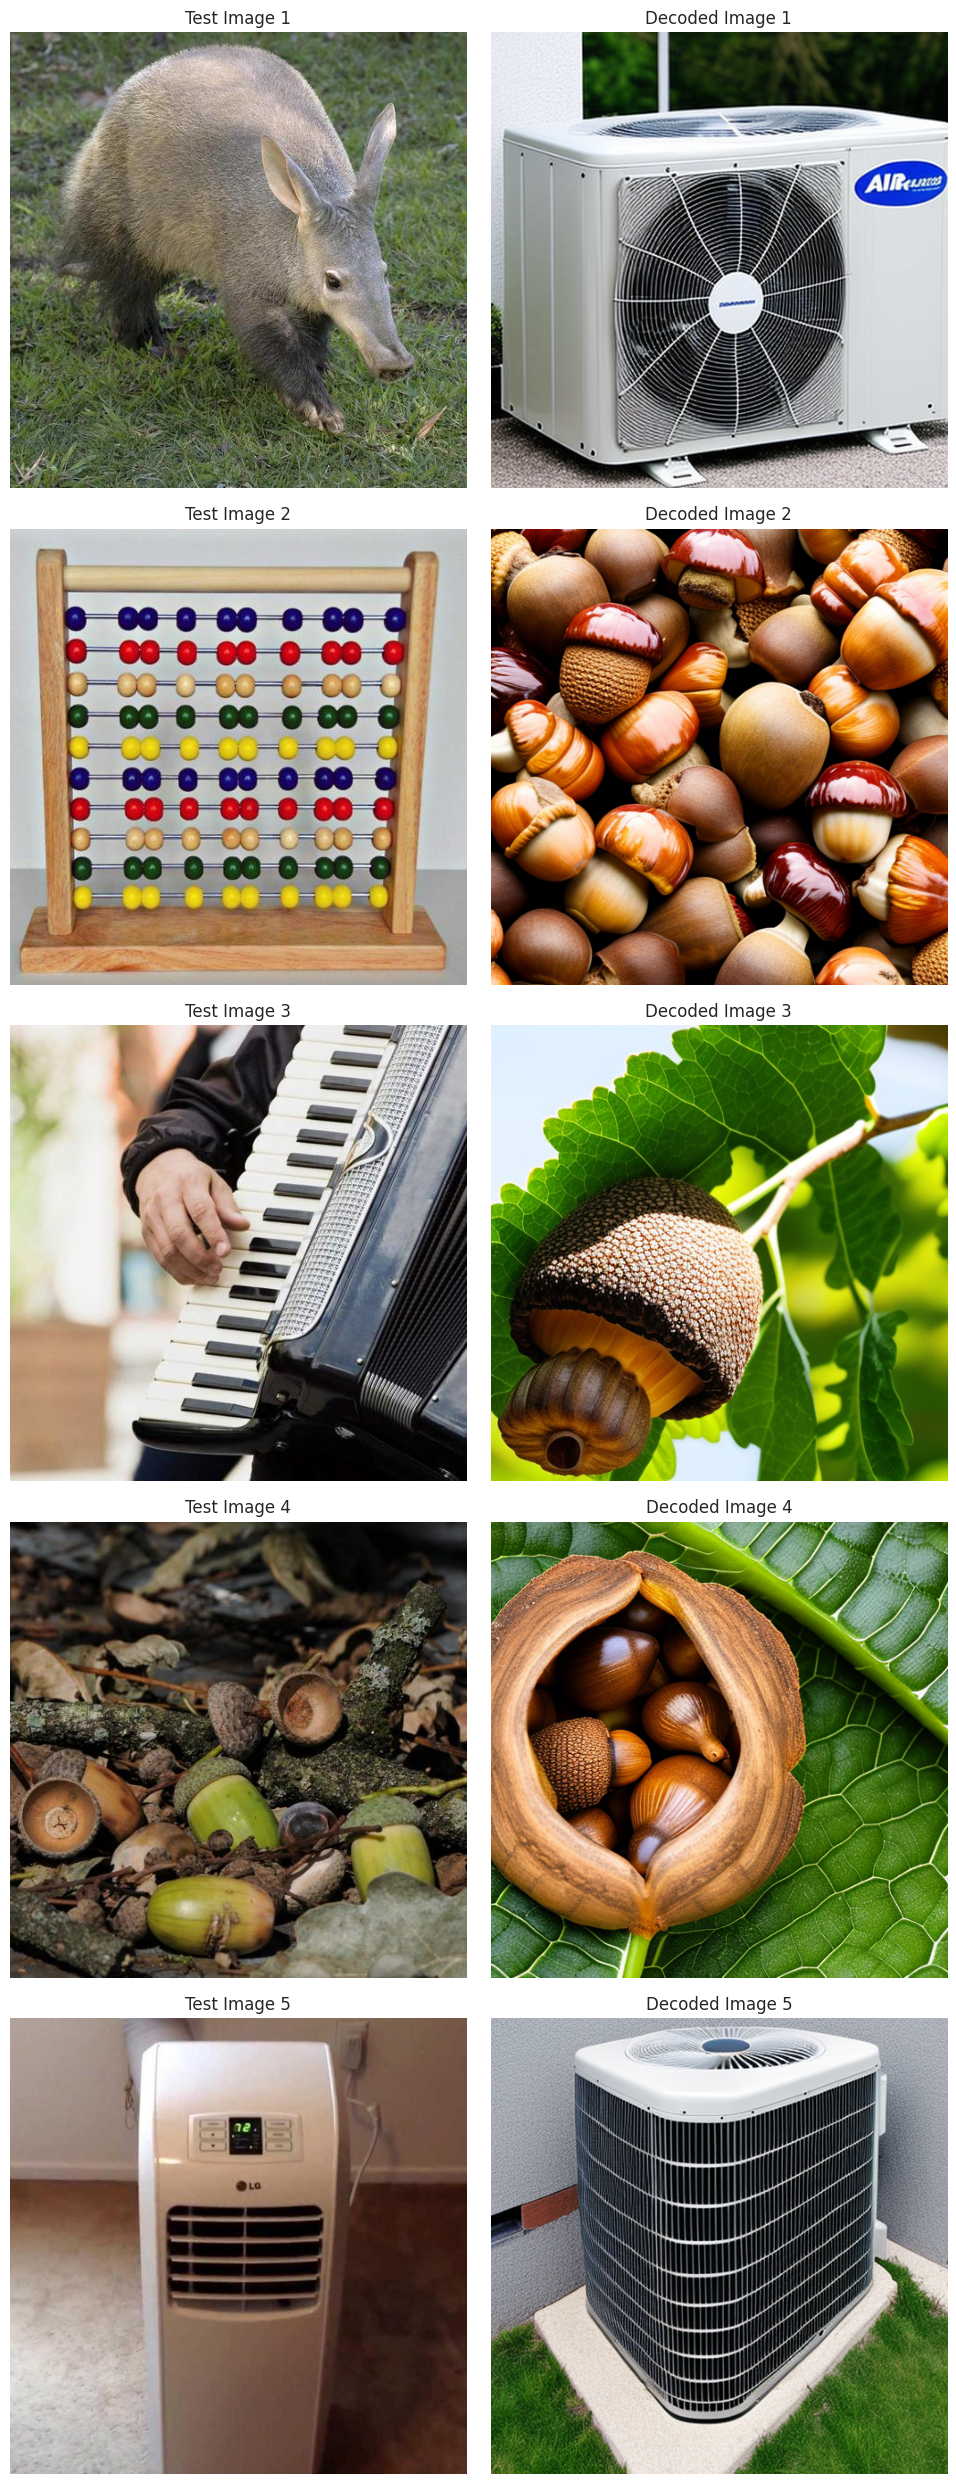

In [75]:
import matplotlib.pyplot as plt

def plot_images(test_images, decoded_images, subj_key="subj_0"):
    # Get the images for the specified subject
    test_imgs = test_images[subj_key]
    decoded_imgs = decoded_images[subj_key]
    
    # Determine number of pairs to plot (minimum of both)
    num_pairs = min(len(test_imgs), len(decoded_imgs))
    
    # Create figure
    fig, axes = plt.subplots(num_pairs, 2, figsize=(10, 5*num_pairs))
    
    # If only one pair, adjust axes array
    if num_pairs == 1:
        axes = axes.reshape(1, 2)
    
    # Plot each pair
    for i in range(num_pairs):
        # Test image
        axes[i, 0].imshow(test_imgs[i])
        axes[i, 0].set_title(f"Test Image {i+1}")
        axes[i, 0].axis('off')
        
        # Decoded image
        axes[i, 1].imshow(decoded_imgs[i])
        axes[i, 1].set_title(f"Decoded Image {i+1}")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
 

# Usage
plot_images(test_images, decoded_images, "subj_0")
